<a href="https://colab.research.google.com/github/DhilipSanjay/ANN-with-Momentum/blob/main/ANN_with_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN with Momentum

## Problem Statement - Intel Image Classification

## Steps
1. Import necessary libraries
1. Download and preprocess the dataset
1. Fix all hyperparameters 
  - Learning rate
  - Number of epochs
  - Number of unit in each layer
  - Momentum
1. Initialize and assign random weights and biases
1. For each training example:
  1. Calculate the output of each unit and propogate through the layers (forward)
  1. Calculate the errors (for output and hidden layers)
  1. Find change in weight (loss)
  1. Update Weights

## Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import h5py

## Dataset


In [2]:
def load_dataset():
  file = "/content/test_catvnoncat.h5"
  if os.path.exists(file) == False:
    !wget https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/test_catvnoncat.h5
    !wget https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/train_catvnoncat.h5
  train_dataset = h5py.File('./train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('./test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
  
  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
  
  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

--2021-03-29 19:00:16--  https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/test_catvnoncat.h5
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/amanchadha/coursera-deep-learning-specialization/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/test_catvnoncat.h5 [following]
--2021-03-29 19:00:16--  https://media.githubusercontent.com/media/amanchadha/coursera-deep-learning-specialization/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/test_catvnoncat.h5
Resolving media.githubusercontent.com (media.githubusercontent.co

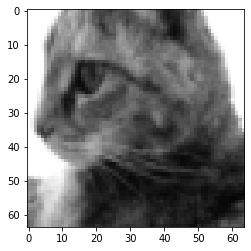

In [3]:
x_train, y_train,x_test, y_test, classes = load_dataset()

plt.imshow(x_test[23])
print(y_test[0,23])

In [4]:
print(x_train.shape)

x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)

x_train = x_train/255
x_test = x_test/255

print("Training data x-values:", x_train.shape)
print("Training data y-values:", y_train.shape)
print("Testing data x-values:", x_test.shape)
print("Testing data y-values:",y_test.shape)

(209, 64, 64, 3)
Training data x-values: (209, 12288, 1)
Training data y-values: (1, 209)
Testing data x-values: (50, 12288, 1)
Testing data y-values: (1, 50)


## Implementation

## Initialize the Weights and Biases for the layers

In [5]:
def initialize_layers(layers):

  np.random.seed(0)
  # Store the weights and biases in dictionary
  WB = {}
  
  for l in range(1, len(layers)):
    # Weight dim = [current layer dim, prev layer dim]
    WB["W" + str(l)] =  np.random.randn(layers[l], layers[l-1]) * 0.01 #np.full((layers[l], layers[l-1]), 0.1)
    print("W"+str(l) , WB["W" + str(l)].shape)

    # Weight gradients initialized to zero (for backprop)
    WB["dW" + str(l)] =  np.zeros((layers[l], layers[l-1]))
    print("dW"+str(l) , WB["dW" + str(l)].shape)

    # Bias dim = [current layer dim]
    WB["b" + str(l)] = np.ones((layers[l], 1)) *0.01 #np.full(layers[l], 0.1)
    print("b"+str(l) , WB["b" + str(l)].shape)

    WB["db" + str(l)] = np.zeros((layers[l], 1))
    print("db"+str(l) , WB["db" + str(l)].shape)

  return WB

## Activation Function

In [6]:
def sigmoid(net):
  '''
  Calculate sigmoid activation value
  '''
  return 1/(1+np.exp(-net))

## Forward Propagation

In [7]:
def linear_activation_forward(X, W, b):
  '''
  Calculate net value
  Calculate the sigmoid activation value for net
  
  History - Stores the inputs, Weights and biases
  '''
  net = np.dot(W, X) + b
  output = sigmoid(net)
  history = (X, W, b)
  
  return output, history

In [8]:
def model_linear_activation_forward(WB, X, layers):
  '''
  For an training example
    store the history
    Calculate it's output
  '''
  output = X
  length = len(layers)
  
  for l in range(1, length):
    output_prev = output
    W = WB["W" + str(l)]
    b = WB["b" + str(l)]
    WB["X" + str(l)] = output_prev
    output, history = linear_activation_forward(output_prev, W, b)
    
  return output, WB

## Backward propagation

In [9]:
def error_output_unit(T, O):
  '''
  T - Target Values
  O - Output Values
  '''
  E = O * (1 - O) * (T - O)

  return E

In [10]:
def error_hidden_unit(W, E, O):
  '''
  W - weight to the next layer
  E - Error calculated for the next layer
  O - Output of the current layer
  '''
  W = W.T
  S = np.sum(np.dot(W, E))
  E = O * (1 - O) * S
  
  return E

In [11]:
def weight_update(W, b, E, X, LR, alpha, prevDW, prevDb):
  '''
  W - original weights
  b - biases
  E - Error values
  X - Input values
  LR - Learning Rate

  dW - weight updates
  db - bias updates

  AW - altered weights
  Ab - altered biases

  alpha - momentum (if 0 -> no momentum)
  prevDW - dW of previous iteration
  prevDb - db of previous iteration
  '''
  dW = LR * np.dot(E, X.T)
  db = LR * E * 1
  # print("dW ", dW.shape)
  AW = W  + dW + (alpha * prevDW)
  Ab = b + db + (alpha * prevDb)
  # print("AW ", AW.shape)

  return AW, dW, Ab, db

In [12]:
def back_prop_output_unit(T, O, W, b, X, LR, alpha, prevDW, prevDb):
  E = error_output_unit(T, O)
  AW, dW, Ab, db = weight_update(W, b, E, X, LR, alpha, prevDW, prevDb)

  return E, AW, dW, Ab, db

def back_prop_hidden_unit(Wnext, Enext, O, W, b, X, LR, alpha, prevDW, prevDb):
  E = error_hidden_unit(Wnext, Enext, O)
  AW, dW, Ab, db = weight_update(W, b, E, X, LR, alpha, prevDW, prevDb)

  return E, AW, dW, Ab, db

In [13]:
def model_back_prop(WB, O, T, LR, layers, alpha):

  length = len(layers) - 1
  W = WB["W" + str(length)] 
  X = WB["X" + str(length)] 
  b = WB["b" + str(length)]
  prevDW = WB["dW" + str(length)] 
  prevDb = WB["db" + str(length)]
  # temp = np.zeros((layers[-1], 1))
  # temp[T] = 1
  # T = temp

  E, W, dW, b, db = back_prop_output_unit(T, O, W, b, X, LR, alpha, prevDW, prevDb)

  # Update dW, db Error (for Adding momentum)
  WB["dW" + str(length)] = dW
  WB["E" + str(length)] = E
  WB["db" + str(length)] = db

  # Update the weights, biases (for Adding momentum)
  WB["W" + str(length)] = W
  WB["b" + str(length)] = b
  
  for l in range(length-1, 0, -1):
    # Next layers's weight and error (previously calculated)
    Wnext = W
    Enext = E

    # Current layer's output (i.e) next layers input
    O = X 

    # Current layer's weights and biases
    W = WB["W" + str(l)] 
    b = WB["b" + str(l)]

    # Input to current layer
    X = WB["X" + str(l)] 
    prevDW = WB["dW" + str(l)] 
    prevDb = WB["db" + str(l)]
    
    # Update weights
    E, W, dW, Ab, db = back_prop_hidden_unit(Wnext, Enext, O, W, b, X, LR, alpha, prevDW, prevDb)
    
    # Update dW, db Error (for Adding momentum)
    WB["dW" + str(l)] = dW
    WB["E" + str(l)] = E
    WB["db" + str(l)] = db

    # Update the weights, biases (for Adding momentum)
    WB["W" + str(l)] = W
    WB["b" + str(l)] = b
  return WB

# Training the model

In [14]:
def train_model(WB, x_train, y_train, num_epochs, LR, layers, alpha):
  total_ex = len(x_train)

  # Run the model for the given number of epochs
  for e in range(num_epochs):
    print("Epoch ", e+1)
    error = 0
    accuracy = 0
    for i in range(total_ex):
      # Forward Propagation
      output, WB = model_linear_activation_forward(WB, x_train[i], layers)
      # Backward Propagation
      WB = model_back_prop(WB, output, y_train[0, i], LR, layers, alpha)
      # Accuracy and Erro
      error += (y_train[0, i] - output) ** 2
      if (output >= 0.5 and y_train[0, i] == 1) or (output < 0.5 and y_train[0, i] == 0):
        accuracy += 1

    # Calculate the final accuracy and error
    final_error = np.squeeze(error)/total_ex
    final_accuracy = accuracy/total_ex
    print("Error: ", final_error, "\tAccuracy: ", final_accuracy)
    
    # To avoid overfitting
    if final_accuracy >= 0.99:
      print("99% Accuracy reached. Stopping the training")
      break

## Testing

In [15]:
def model_predict(WB, X, layers):
  output = X
  
  for l in range(1, len(layers)):
    output_prev = output
    W = WB["W" + str(l)]
    b = WB["b" + str(l)]
    output, history = linear_activation_forward(output_prev, W, b)

  return output

In [16]:
def test_model(WB, x_test, y_test, layers):
  total_ex = len(x_test)
  error = 0
  accuracy = 0
  # Predict for all the test examples
  for i in range(total_ex):
    output = model_predict(WB, x_test[i], layers)
    print("Predicted Output: ", np.squeeze(output),  "\tTest Output: ", y_test[0, i])

    # Calculate the error and accuracy
    error += (y_test[0, i] - output) ** 2
    if (output >= 0.5 and y_test[0, i] == 1) or (output < 0.5 and y_test[0, i] == 0):
      accuracy += 1

  # Calculate the final accuracy and error
  final_error = np.squeeze(error)/total_ex
  final_accuracy = accuracy/total_ex
  print("Error: ", final_error, "\tAccuracy: ", final_accuracy)

## ANN Without Mometum

In [17]:
input_layer = x_train.shape[1]
hidden_1 = 16
output_layer = 1 
layers = [input_layer, hidden_1, output_layer]
WB = initialize_layers(layers)

num_epochs = 1000
LR = 0.005
alpha = 0
train_model(WB, x_train, y_train, num_epochs, LR, layers, alpha)

W1 (16, 12288)
dW1 (16, 12288)
b1 (16, 1)
db1 (16, 1)
W2 (1, 16)
dW2 (1, 16)
b2 (1, 1)
db2 (1, 1)
Epoch  1
Error:  0.24518000518117347 	Accuracy:  0.6076555023923444
Epoch  2
Error:  0.232024685556671 	Accuracy:  0.6555023923444976
Epoch  3
Error:  0.22786286269784647 	Accuracy:  0.6555023923444976
Epoch  4
Error:  0.22700473319957112 	Accuracy:  0.6555023923444976
Epoch  5
Error:  0.22671195879924239 	Accuracy:  0.6555023923444976
Epoch  6
Error:  0.2264754833616841 	Accuracy:  0.6555023923444976
Epoch  7
Error:  0.22608212328027524 	Accuracy:  0.6555023923444976
Epoch  8
Error:  0.22524153936126093 	Accuracy:  0.6555023923444976
Epoch  9
Error:  0.2238009694895659 	Accuracy:  0.6555023923444976
Epoch  10
Error:  0.22198679397136084 	Accuracy:  0.6555023923444976
Epoch  11
Error:  0.2198902281560077 	Accuracy:  0.6555023923444976
Epoch  12
Error:  0.21758354180739717 	Accuracy:  0.6555023923444976
Epoch  13
Error:  0.21508155027380352 	Accuracy:  0.6555023923444976
Epoch  14
Error:  0

In [18]:
# Without momentum test accuracy
test_model(WB, x_test, y_test, layers)

Predicted Output:  0.884018606053419 	Test Output:  1
Predicted Output:  0.8801337093945197 	Test Output:  1
Predicted Output:  0.885957128233154 	Test Output:  1
Predicted Output:  0.8763607305092223 	Test Output:  1
Predicted Output:  0.8577568765633424 	Test Output:  1
Predicted Output:  0.5926362158765595 	Test Output:  0
Predicted Output:  0.09486923341259497 	Test Output:  1
Predicted Output:  0.8834401260861943 	Test Output:  1
Predicted Output:  0.882482851720598 	Test Output:  1
Predicted Output:  0.8404548679885894 	Test Output:  1
Predicted Output:  0.4804485468995511 	Test Output:  1
Predicted Output:  0.8333873685054028 	Test Output:  1
Predicted Output:  0.825442147927578 	Test Output:  1
Predicted Output:  0.8857333926454172 	Test Output:  0
Predicted Output:  0.01276133521973673 	Test Output:  0
Predicted Output:  0.8588312604619821 	Test Output:  1
Predicted Output:  0.016115291607261863 	Test Output:  0
Predicted Output:  0.872504329988477 	Test Output:  1
Predicted O

## ANN With Mometum

In [19]:
input_layer = x_train.shape[1]
hidden_1 = 16
output_layer = 1 
layers = [input_layer, hidden_1, output_layer]
WB = initialize_layers(layers)

num_epochs = 1000
LR = 0.005
alpha = 0.1
train_model(WB, x_train, y_train, num_epochs, LR, layers, alpha)

W1 (16, 12288)
dW1 (16, 12288)
b1 (16, 1)
db1 (16, 1)
W2 (1, 16)
dW2 (1, 16)
b2 (1, 1)
db2 (1, 1)
Epoch  1
Error:  0.24450183805787812 	Accuracy:  0.5980861244019139
Epoch  2
Error:  0.2311361608177761 	Accuracy:  0.6555023923444976
Epoch  3
Error:  0.227628882598047 	Accuracy:  0.6555023923444976
Epoch  4
Error:  0.22695872529232824 	Accuracy:  0.6555023923444976
Epoch  5
Error:  0.22668482471442528 	Accuracy:  0.6555023923444976
Epoch  6
Error:  0.2263666548624873 	Accuracy:  0.6555023923444976
Epoch  7
Error:  0.22568919568678444 	Accuracy:  0.6555023923444976
Epoch  8
Error:  0.22428481192422614 	Accuracy:  0.6555023923444976
Epoch  9
Error:  0.22240345929627142 	Accuracy:  0.6555023923444976
Epoch  10
Error:  0.22019112495443416 	Accuracy:  0.6555023923444976
Epoch  11
Error:  0.21773919901956923 	Accuracy:  0.6555023923444976
Epoch  12
Error:  0.21511327062617558 	Accuracy:  0.6555023923444976
Epoch  13
Error:  0.21242100045190349 	Accuracy:  0.6555023923444976
Epoch  14
Error:  

In [20]:
# With momentum test accuracy
test_model(WB, x_test, y_test, layers)

Predicted Output:  0.8822257683483712 	Test Output:  1
Predicted Output:  0.8752615558300514 	Test Output:  1
Predicted Output:  0.8826063861089379 	Test Output:  1
Predicted Output:  0.8756879141874951 	Test Output:  1
Predicted Output:  0.8495914158993794 	Test Output:  1
Predicted Output:  0.5731870298604704 	Test Output:  0
Predicted Output:  0.09355699347900902 	Test Output:  1
Predicted Output:  0.8805175265482263 	Test Output:  1
Predicted Output:  0.8795129153242215 	Test Output:  1
Predicted Output:  0.8317392726051875 	Test Output:  1
Predicted Output:  0.4982312352512401 	Test Output:  1
Predicted Output:  0.8356181832307548 	Test Output:  1
Predicted Output:  0.8254185658399451 	Test Output:  1
Predicted Output:  0.8823591030114804 	Test Output:  0
Predicted Output:  0.01721358088489199 	Test Output:  0
Predicted Output:  0.8620711931353103 	Test Output:  1
Predicted Output:  0.01555776671073621 	Test Output:  0
Predicted Output:  0.8680480315609085 	Test Output:  1
Predict

## Test with your own image

In [30]:
import cv2
from google.colab import files

# Change the size according to the training example
image_resize = 64
uploaded = files.upload()

for fn in uploaded.keys():
  image = plt.imread(fn)
  image_np = cv2.resize(image, (image_resize,image_resize))
  image_np = image_np.reshape(-1, 1) / 255
  output = model_predict(WB, image_np, layers)
  print("Predicted Output: ", np.squeeze(output))
  if output >= 0.5:
    print(fn + " is a cat image")
  else:
    print(fn + " is not a cat image")
  print("--------------------------\n\n")

Saving butterfly.jpg to butterfly.jpg
Saving car.jfif to car (1).jfif
Saving cat 1.jfif to cat 1 (2).jfif
Saving cat 2.jpg to cat 2.jpg
Saving dog.jpg to dog (2).jpg
Predicted Output:  0.2100706088328189
butterfly.jpg is not a cat image
--------------------------


Predicted Output:  0.7278856125758412
car.jfif is a cat image
--------------------------


Predicted Output:  0.8660883890534717
cat 1.jfif is a cat image
--------------------------


Predicted Output:  0.7973523207378205
cat 2.jpg is a cat image
--------------------------


Predicted Output:  0.030647210564542754
dog.jpg is not a cat image
--------------------------




## References
- [Step by Step Deep Neural Network](https://github.com/amanchadha/coursera-deep-learning-specialization/tree/master/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%204/Building%20your%20Deep%20Neural%20Network%20-%20Step%20by%20Step)